In [3]:
# necessary imports

import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib
import pickle
import time

from tenpy.networks.mps import MPS
from tenpy.models.hubbard import BoseHubbardChain

from tenpy.algorithms import dmrg
from tenpy.algorithms import tebd
from tenpy.algorithms import tdvp

# folder to store
folder = "store"

In [4]:
# observables to evaluate during time evolution

def observables(eng, data):
    keys = ['t', 'entropy', 'N', 'B', 'g1', 'g2', 'trunc_err']
    if data is None:
        data = dict([(k, []) for k in keys])
    data['t'].append(eng.evolved_time)
    data['entropy'].append(eng.psi.entanglement_entropy())
    data['N'].append(eng.psi.expectation_value('N'))
    data['g1'].append(eng.psi.correlation_function('Bd', 'B'))
    data['g2'].append(eng.psi.correlation_function('N', 'N'))
    data['trunc_err'].append(eng.trunc_err.eps)
    return data

# to save after each time step on drive
def save_obj(obj, name ):
  with open(folder + name + '.pkl', 'wb') as f:
      pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [12]:
# system parameters

N_site = 20 # length
filling = 1. # occupation
bc_MPS = 'infinite'

U0 = 0. # initial interaction (for DMRG)
U = U0 # interaction after quench (TE)
J = 0.5 # tunneling
V = 0. # nearest-neighbor interaction
mu = 0. # chemical potential

# starting potential V0*exp( -(x-x0)**2/sigma**2 )
V0 = -0.001
x0 = N_site/2.
sigma = 0.01*N_site

n_max = 7 # maximal occupation

# numerical parameters dmrg
dmrg_params = {
    'trunc_params': {
        'chi_max': 300,
        'svd_min': 1.e-8,
    },
    'update_env': 5,
    'start_env': 5,
    'max_E_err': 0.0001,
    'max_S_err': 0.0001,
    'max_sweeps': 5, 
    'mixer': False,

}

In [13]:
# DMRG initial state

# number of particles in system
N_particle = int(filling*N_site)

# the potential
x = np.linspace(0,N_site-1,N_site)
potential = V0*np.exp( -(x-x0)**2/sigma**2 )

# Hamiltonian with J_start = 0
model_params = dict(L=N_site, t=J, U=U0, V=V, mu=mu, bc_MPS=bc_MPS, conserve="N", n_max=n_max)
BH0 = BoseHubbardChain(model_params)
#BH0.n_max = n_max
BH0.add_onsite(potential, 0, "N", category=None)
BH0.init_H_from_terms()

# initial state
occ = np.zeros(N_site, dtype="int")
occ[:N_particle] = 1
occ = np.roll(occ,(N_site-N_particle)//2 )
psi = MPS.from_product_state(BH0.lat.mps_sites(), occ, bc=BH0.lat.bc_MPS)

# TEBD engine
#eng = dmrg.DMRGEngine(psi, BH0, dmrg_params)
#info = dmrg.run(psi, BH0, dmrg_params)
start = time.time()
eng = dmrg.TwoSiteDMRGEngine(psi, BH0, dmrg_params)
E, psi = eng.run()

print("time elapsed: {:.2f}s".format(time.time()-start))

<ipython-input-13-7be58f301699>:14: UserWarning: Adding terms to the CouplingMPOModel after initialization. Make sure you call `init_H_from_terms` again! In that case, you can set `self.manually_call_init_H` to supress this warning.
  BH0.add_onsite(potential, 0, "N", category=None)
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=7.12e-05


time elapsed: 823.20s


Max occ: 1.0064191300944818
Particles: 20.00001907471705


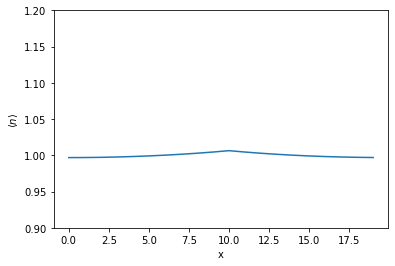

In [14]:
# n=7
occ_start = eng.psi.expectation_value('N')

plt.plot(occ_start)
plt.xlabel('x')
plt.ylabel(r'$\langle n \rangle$')
plt.ylim([0.9,1.2])
print('Max occ: {}'.format(np.max(occ_start)))
print('Particles: {}'.format(np.sum(occ_start)))

In [20]:
# numerical parameters TEBD
tebd_params = { # everything for TEBD
    'order': 4,
    'dt': 0.1,
    'N_steps': 5,
    'max_error_E': 1.e-6,
    'trunc_params': {
        'chi_max': 300,
        'svd_min': 1.e-7
    },
    'verbose': 10,
}

t_ev = 20.
save = True
prefix = "/data_infinite_"

# make model with params above
model_params = dict(L=N_site, t=J, U=U, V=V, mu=mu, bc_MPS=bc_MPS, conserve="N", n_max=n_max)
BH = BoseHubbardChain(model_params)

# TEBD engine with DMRG obtained psi
eng = tebd.TEBDEngine(psi, BH, tebd_params)

# intialize data
data = observables(eng, None)

# the count and number of time steps
i = 0;
i_tot = int(t_ev / tebd_params["dt"] / tebd_params["N_steps"])

start = time.time()

while eng.evolved_time < t_ev:
    
    t_start = time.time()
    eng.run()
    observables(eng, data)

    if save:
      # file to save all collected data
      suffix = "N_" + str(N_site) + "_V0_" + "{:.2f}".format(V0) + "_U_" + "{:.2f}".format(U) + "_J_" + "{:.2f}".format(J) + "_T_" + "{:.2f}".format(t_ev)
      filename = prefix + suffix
      save_obj(data,filename)


    i += 1
    print("run " + str(i) + " of " + str(i_tot) + " finished in {:.2f}s".format(time.time()-t_start))
    
print("Full run finished in {:.2f}s".format(time.time()-start))

/jet/home/mathvr/.local/lib/python3.8/site-packages/tenpy/tools/params.py:223: UserWarning: unused options for config TEBDEngine:
['max_error_E', 'verbose']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


run 1 of 40 finished
run 2 of 40 finished
run 3 of 40 finished
run 4 of 40 finished
run 5 of 40 finished
run 6 of 40 finished
run 7 of 40 finished
run 8 of 40 finished
run 9 of 40 finished
run 10 of 40 finished
run 11 of 40 finished
run 12 of 40 finished
run 13 of 40 finished
run 14 of 40 finished
run 15 of 40 finished
run 16 of 40 finished
run 17 of 40 finished
run 18 of 40 finished
run 19 of 40 finished
run 20 of 40 finished
run 21 of 40 finished
run 22 of 40 finished
run 23 of 40 finished
run 24 of 40 finished
run 25 of 40 finished
run 26 of 40 finished
run 27 of 40 finished
run 28 of 40 finished
run 29 of 40 finished
run 30 of 40 finished
run 31 of 40 finished
run 32 of 40 finished
run 33 of 40 finished
run 34 of 40 finished
run 35 of 40 finished
run 36 of 40 finished
run 37 of 40 finished
run 38 of 40 finished
run 39 of 40 finished
run 40 of 40 finished
